# Import Libraries

In [1]:
import argparse
import math
import os
import os.path as ops
import time

import cv2
import glog as log
import numpy as np
import tensorflow as tf

from easydict import EasyDict as edict
from collections import OrderedDict
import matplotlib.pyplot as plt

In [2]:
# ignore warning for tf 2.0
tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
print(tf.__version__)

1.13.0-rc2


# Setting Data Set and Weights Path

In [4]:
# dataset_dir = 'data/training_data_100/'
# dataset_dir = 'data/training_data/'
# dataset_dir = 'data/training_data_gamma_0d4/'
dataset_dir = 'data/training_data_bdd100k/'

# weights_path = None
weights_path = 'model/tusimple_lanenet/tusimple_lanenet_vgg_2018-10-19-13-33-56.ckpt-200000'

# Setting parameters

In [5]:
__C = edict()

cfg = __C

__C.TRAIN = edict()
__C.TRAIN.EPOCHS = 10000
__C.TRAIN.NOOFBATCHES = 10
__C.TRAIN.MOMENTUM = 0.9
__C.TRAIN.LEARNING_RATE = 0.0005
__C.TRAIN.GPU_MEMORY_FRACTION = 0.85
__C.TRAIN.TF_ALLOW_GROWTH = True
__C.TRAIN.BATCH_SIZE = 8
__C.TRAIN.IMG_HEIGHT = 256
__C.TRAIN.IMG_WIDTH = 512

# Reading Data Set

In [6]:
class DataSet(object):
    def __init__(self, dataset_info_file):
        self._gt_img_list, self._gt_label_binary_list = self._init_dataset(dataset_info_file)
        self._random_dataset()
        self._next_batch_loop_count = 0

    def _init_dataset(self, dataset_info_file):
        gt_img_list = []
        gt_label_binary_list = []

        assert ops.exists(dataset_info_file), '{:s}　does not exist'.format(dataset_info_file)

        with open(dataset_info_file, 'r') as file:
            for _info in file:
                info_tmp = _info.strip(' ').split()

                gt_img_list.append(info_tmp[0])
                gt_label_binary_list.append(info_tmp[1])

        return gt_img_list, gt_label_binary_list

    def _random_dataset(self):
        assert len(self._gt_img_list) == len(self._gt_label_binary_list)

        random_idx = np.random.permutation(len(self._gt_img_list))
        new_gt_img_list = []
        new_gt_label_binary_list = []

        for index in random_idx:
            new_gt_img_list.append(self._gt_img_list[index])
            new_gt_label_binary_list.append(self._gt_label_binary_list[index])

        self._gt_img_list = new_gt_img_list
        self._gt_label_binary_list = new_gt_label_binary_list

    def next_batch(self, batch_size):
        assert len(self._gt_label_binary_list) == len(self._gt_img_list)

        idx_start = batch_size * self._next_batch_loop_count
        idx_end = batch_size * self._next_batch_loop_count + batch_size

        if idx_start == 0 and idx_end > len(self._gt_label_binary_list):
            raise ValueError('Batch size cannot be larger than the total number of samples', 
                             idx_end, len(self._gt_label_binary_list))

        if idx_end > len(self._gt_label_binary_list):
            self._random_dataset()
            self._next_batch_loop_count = 0
            return self.next_batch(batch_size)
        else:
            gt_img_list = self._gt_img_list[idx_start:idx_end]
            gt_label_binary_list = self._gt_label_binary_list[idx_start:idx_end]

            gt_imgs = []
            gt_labels_binary = []

            for gt_img_path in gt_img_list:
                gt_imgs.append(cv2.imread(gt_img_path, cv2.IMREAD_COLOR))

            for gt_label_path in gt_label_binary_list:
                label_img = cv2.imread(gt_label_path, cv2.IMREAD_COLOR)
                label_binary = np.zeros([label_img.shape[0], label_img.shape[1]], dtype=np.uint8)
                idx = np.where((label_img[:, :, :] != [0, 0, 0]).all(axis=2))
                label_binary[idx] = 1
                gt_labels_binary.append(label_binary)

            self._next_batch_loop_count += 1

        return gt_imgs, gt_labels_binary

In [7]:
# train dataset
train_dataset_file = ops.join(dataset_dir, 'train.txt')
assert ops.exists(train_dataset_file)
train_dataset = DataSet(train_dataset_file)

# CNN Base Function
## cnn_basenet.py

In [8]:
class CNNBaseModel(object):
    def __init__(self):
        pass

    @staticmethod
    def conv2d(inputdata, out_channel, kernel_size, padding='SAME',
               stride=1, w_init=None, b_init=None,
               split=1, use_bias=True, data_format='NHWC', name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'NHWC' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Conv2D] Input cannot have unknown channel!"
            assert in_channel % split == 0
            assert out_channel % split == 0

            padding = padding.upper()

            if isinstance(kernel_size, list):
                filter_shape = [kernel_size[0], kernel_size[1]] + [in_channel / split, out_channel]
            else:
                filter_shape = [kernel_size, kernel_size] + [in_channel / split, out_channel]

            if isinstance(stride, list):
                strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                    else [1, 1, stride[0], stride[1]]
            else:
                strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                    else [1, 1, stride, stride]

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            w = tf.get_variable('W', filter_shape, initializer=w_init)
            b = None

            if use_bias:
                b = tf.get_variable('b', [out_channel], initializer=b_init)

            if split == 1:
                conv = tf.nn.conv2d(inputdata, w, strides, padding, data_format=data_format)
            else:
                inputs = tf.split(inputdata, split, channel_axis)
                kernels = tf.split(w, split, 3)
                outputs = [tf.nn.conv2d(i, k, strides, padding, data_format=data_format)
                           for i, k in zip(inputs, kernels)]
                conv = tf.concat(outputs, channel_axis)

            ret = tf.identity(tf.nn.bias_add(conv, b, data_format=data_format) if use_bias else conv, name=name)

        return ret

    @staticmethod
    def relu(inputdata, name=None):
        return tf.nn.relu(features=inputdata, name=name)

    @staticmethod
    def maxpooling(inputdata, kernel_size, stride=None, \
                   padding='VALID', data_format='NHWC', name=None):
        padding = padding.upper()

        if stride is None:
            stride = kernel_size

        if isinstance(kernel_size, list):
            kernel = [1, kernel_size[0], kernel_size[1], 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size[0], kernel_size[1]]
        else:
            kernel = [1, kernel_size, kernel_size, 1] if data_format == 'NHWC' \
                else [1, 1, kernel_size, kernel_size]

        if isinstance(stride, list):
            strides = [1, stride[0], stride[1], 1] if data_format == 'NHWC' \
                else [1, 1, stride[0], stride[1]]
        else:
            strides = [1, stride, stride, 1] if data_format == 'NHWC' \
                else [1, 1, stride, stride]

        return tf.nn.max_pool(value=inputdata, ksize=kernel, strides=strides, \
                              padding=padding, data_format=data_format, name=name)

    @staticmethod
    def layerbn(inputdata, is_training, name):
        return tf.layers.batch_normalization(inputs=inputdata, training=is_training, name=name)

    @staticmethod
    def deconv2d(inputdata, out_channel, kernel_size, padding='SAME',
                 stride=1, w_init=None, b_init=None,
                 use_bias=True, activation=None, data_format='channels_last',
                 trainable=True, name=None):
        with tf.variable_scope(name):
            in_shape = inputdata.get_shape().as_list()
            channel_axis = 3 if data_format == 'channels_last' else 1
            in_channel = in_shape[channel_axis]
            assert in_channel is not None, "[Deconv2D] Input cannot have unknown channel!"

            padding = padding.upper()

            if w_init is None:
                w_init = tf.contrib.layers.variance_scaling_initializer()
            if b_init is None:
                b_init = tf.constant_initializer()

            ret = tf.layers.conv2d_transpose(inputs=inputdata, filters=out_channel,
                                             kernel_size=kernel_size,
                                             strides=stride, padding=padding,
                                             data_format=data_format,
                                             activation=activation, use_bias=use_bias,
                                             kernel_initializer=w_init,
                                             bias_initializer=b_init, trainable=trainable,
                                             name=name)
        return ret

# Defining model using conv2d, Relu and Maxpooling

## fcn_decoder.py

In [9]:
class FCNDecoder(CNNBaseModel):
    def __init__(self, phase):
        super(FCNDecoder, self).__init__()

    def decode(self, input_tensor_dict, decode_layer_list, name):
        ret = dict()

        with tf.variable_scope(name):
            # score stage 1
            input_tensor = input_tensor_dict[decode_layer_list[0]]['data']

            score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                kernel_size=1, use_bias=False, name='score_origin')
            decode_layer_list = decode_layer_list[1:]
            for i in range(len(decode_layer_list)):
                deconv = self.deconv2d(inputdata=score, out_channel=64, kernel_size=4,
                                       stride=2, use_bias=False, name='deconv_{:d}'.format(i + 1))
                input_tensor = input_tensor_dict[decode_layer_list[i]]['data']
                score = self.conv2d(inputdata=input_tensor, out_channel=64,
                                    kernel_size=1, use_bias=False, name='score_{:d}'.format(i + 1))
                fused = tf.add(deconv, score, name='fuse_{:d}'.format(i + 1))
                score = fused

            deconv_final = self.deconv2d(inputdata=score, out_channel=64, kernel_size=16,
                                         stride=8, use_bias=False, name='deconv_final')

            score_final = self.conv2d(inputdata=deconv_final, out_channel=2,
                                      kernel_size=1, use_bias=False, name='score_final')

            ret['logits'] = score_final

        return ret

## vgg_encoder.py
https://github.com/machrisaa/tensorflow-vgg

In [10]:
class VGG16Encoder(CNNBaseModel):
    def __init__(self, phase):
        super(VGG16Encoder, self).__init__()
        self._train_phase = tf.constant('train', dtype=tf.string)
        self._phase = phase
        self._is_training = self._init_phase()

    def _init_phase(self):
        return tf.equal(self._phase, self._train_phase)

    def _conv_stage(self, input_tensor, k_size, out_dims, name,
                    stride=1, pad='SAME'):
        with tf.variable_scope(name):
            conv = self.conv2d(inputdata=input_tensor, out_channel=out_dims,
                               kernel_size=k_size, stride=stride,
                               use_bias=False, padding=pad, name='conv')

            bn = self.layerbn(inputdata=conv, is_training=self._is_training, name='bn')

            relu = self.relu(inputdata=bn, name='relu')

            return relu

    def encode(self, input_tensor, name):
        ret = OrderedDict()

        with tf.variable_scope(name):
            # conv stage 1
            conv_1_1 = self._conv_stage(input_tensor=input_tensor, k_size=3, out_dims=64, name='conv1_1')
            conv_1_2 = self._conv_stage(input_tensor=conv_1_1, k_size=3, out_dims=64, name='conv1_2')
            pool1 = self.maxpooling(inputdata=conv_1_2, kernel_size=2, stride=2, name='pool1')

            # conv stage 2
            conv_2_1 = self._conv_stage(input_tensor=pool1, k_size=3, out_dims=128, name='conv2_1')
            conv_2_2 = self._conv_stage(input_tensor=conv_2_1, k_size=3, out_dims=128, name='conv2_2')
            pool2 = self.maxpooling(inputdata=conv_2_2, kernel_size=2, stride=2, name='pool2')

            # conv stage 3
            conv_3_1 = self._conv_stage(input_tensor=pool2, k_size=3, out_dims=256, name='conv3_1')
            conv_3_2 = self._conv_stage(input_tensor=conv_3_1, k_size=3, out_dims=256, name='conv3_2')
            conv_3_3 = self._conv_stage(input_tensor=conv_3_2, k_size=3, out_dims=256, name='conv3_3')
            pool3 = self.maxpooling(inputdata=conv_3_3, kernel_size=2, stride=2, name='pool3')
            ret['pool3'] = dict()
            ret['pool3']['data'] = pool3
            ret['pool3']['shape'] = pool3.get_shape().as_list()

            # conv stage 4
            conv_4_1 = self._conv_stage(input_tensor=pool3, k_size=3, out_dims=512, name='conv4_1')
            conv_4_2 = self._conv_stage(input_tensor=conv_4_1, k_size=3, out_dims=512, name='conv4_2')
            conv_4_3 = self._conv_stage(input_tensor=conv_4_2, k_size=3, out_dims=512, name='conv4_3')
            pool4 = self.maxpooling(inputdata=conv_4_3, kernel_size=2, stride=2, name='pool4')
            ret['pool4'] = dict()
            ret['pool4']['data'] = pool4
            ret['pool4']['shape'] = pool4.get_shape().as_list()

            # conv stage 5
            conv_5_1 = self._conv_stage(input_tensor=pool4, k_size=3, out_dims=512, name='conv5_1')
            conv_5_2 = self._conv_stage(input_tensor=conv_5_1, k_size=3, out_dims=512, name='conv5_2')
            conv_5_3 = self._conv_stage(input_tensor=conv_5_2, k_size=3, out_dims=512, name='conv5_3')
            pool5 = self.maxpooling(inputdata=conv_5_3, kernel_size=2, stride=2, name='pool5')
            ret['pool5'] = dict()
            ret['pool5']['data'] = pool5
            ret['pool5']['shape'] = pool5.get_shape().as_list()

        return ret

## lanenet_merge_model.py

In [11]:
class LaneNet():
    def __init__(self, phase):
        super(LaneNet, self).__init__()
        self._encoder = VGG16Encoder(phase=phase)
        self._decoder = FCNDecoder(phase=phase)
        return

    def _build_model(self, input_tensor, name):
        with tf.variable_scope(name):
            # first encode
            encode_ret = self._encoder.encode(input_tensor=input_tensor,
                                              name='encode')
            # second decode
            decode_ret = self._decoder.decode(input_tensor_dict=encode_ret,
                                              name='decode',
                                              decode_layer_list=['pool5',
                                                                 'pool4',
                                                                 'pool3'])
            return decode_ret

    def compute_loss(self, input_tensor, binary_label, name):
        with tf.variable_scope(name):
            # Forward propagation to get logits
            inference_ret = self._build_model(input_tensor=input_tensor, name='inference')

            # Calculate the binary partition loss function
            decode_logits = inference_ret['logits']
            binary_label_plain = tf.reshape(binary_label,
                                            shape=[binary_label.get_shape().as_list()[0] *
                                                   binary_label.get_shape().as_list()[1] *
                                                   binary_label.get_shape().as_list()[2]])
            # Add class weights
            unique_labels, unique_id, counts = tf.unique_with_counts(binary_label_plain)
            counts = tf.cast(counts, tf.float32)
            inverse_weights = tf.divide(1.0,
                                        tf.log(tf.add(tf.divide(tf.constant(1.0), counts),
                                                      tf.constant(1.02))))
            inverse_weights = tf.gather(inverse_weights, binary_label)
            binary_segmenatation_loss = tf.losses.sparse_softmax_cross_entropy(labels=binary_label, \
                                                                               logits=decode_logits, \
                                                                               weights=inverse_weights)
            binary_segmenatation_loss = tf.reduce_mean(binary_segmenatation_loss)

            ret = {'loss': binary_segmenatation_loss, 'binary_seg_logits': decode_logits}

            return ret

# Define cost, optimizer and accuracy

In [12]:
CFG = cfg

In [13]:
with tf.device('/gpu:0'):
    input_tensor = tf.placeholder(dtype=tf.float32,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 3],
                                  name='input_tensor')
    binary_label = tf.placeholder(dtype=tf.int64,
                                  shape=[CFG.TRAIN.BATCH_SIZE, CFG.TRAIN.IMG_HEIGHT,
                                         CFG.TRAIN.IMG_WIDTH, 1],
                                         name='binary_label')

    # Create the model
    phase = tf.placeholder(dtype=tf.string, shape=None, name='net_phase')
    net = LaneNet(phase=phase)

    # Define loss
    compute_ret = net.compute_loss(input_tensor=input_tensor, binary_label=binary_label, name='lanenet_model')
    loss = compute_ret['loss']

    # Evaluate model
    out_logits = compute_ret['binary_seg_logits']
    out_logits = tf.nn.softmax(logits=out_logits)
    out_logits_out = tf.argmax(out_logits, axis=-1)
    out = tf.argmax(out_logits, axis=-1)
    out = tf.expand_dims(out, axis=-1)

    idx = tf.where(tf.equal(binary_label, 1))
    pix_cls_ret = tf.gather_nd(out, idx)
    accuracy = tf.count_nonzero(pix_cls_ret)
    accuracy = tf.divide(accuracy, tf.cast(tf.shape(pix_cls_ret)[0], tf.int64))

    # Define optimizer
    global_step = tf.Variable(0, trainable=False)
    learning_rate = tf.train.exponential_decay(CFG.TRAIN.LEARNING_RATE, global_step,
                                               100000, 0.1, staircase=True)
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, \
                                               momentum=CFG.TRAIN.MOMENTUM).minimize(loss=loss,
                                                                                     var_list=tf.trainable_variables(),
                                                                                     global_step=global_step)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Set a session

In [14]:
# Set sess configuration
sess_config = tf.ConfigProto(allow_soft_placement=True)
sess_config.gpu_options.per_process_gpu_memory_fraction = CFG.TRAIN.GPU_MEMORY_FRACTION
sess_config.gpu_options.allow_growth = CFG.TRAIN.TF_ALLOW_GROWTH
sess_config.gpu_options.allocator_type = 'BFC'

sess = tf.Session(config=sess_config)

In [15]:
# Set tf saver
model_save_dir = 'model/tusimple_lanenet'
if not ops.exists(model_save_dir):
    os.makedirs(model_save_dir)

train_start_time = time.strftime('%Y-%m-%d-%H-%M-%S', time.localtime(time.time()))
model_name = 'tusimple_lanenet_{:s}.ckpt'.format(str(train_start_time))
model_save_path = ops.join(model_save_dir, model_name)

saver = tf.train.Saver()

tf.train.write_graph(graph_or_graph_def=sess.graph, logdir='',
                     name='{:s}/lanenet_model.pb'.format(model_save_dir))

'model/tusimple_lanenet/lanenet_model.pb'

In [16]:
# Set tf summary
tboard_save_path = 'tboard/tusimple_lanenet_{:s}'.format(str(train_start_time))
if not ops.exists(tboard_save_path):
    os.makedirs(tboard_save_path)

train_accuracy_scalar = tf.summary.scalar(name='train_accuracy', tensor=accuracy)
train_loss_scalar = tf.summary.scalar(name='train_loss', tensor=loss)
learning_rate_scalar = tf.summary.scalar(name='learning_rate', tensor=learning_rate)
merged_summary_op = tf.summary.merge([train_accuracy_scalar, train_loss_scalar, learning_rate_scalar])

summary_writer = tf.summary.FileWriter(tboard_save_path)
summary_writer.add_graph(sess.graph)

In [17]:
# Set output image folder
image_save_path = 'data_ret/tusimple_lanenet_{:s}'.format(str(train_start_time))
if not ops.exists(image_save_path):
    os.makedirs(image_save_path)

# Running the session

In [18]:
VGG_MEAN = [103.939, 116.779, 123.68]

history = []
train_cost_time_mean = []

In [19]:
def resize_training_data(gt_imgs, binary_gt_labels):
    gt_imgs = [cv2.resize(tmp,
                          dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                          dst=tmp,
                          interpolation=cv2.INTER_LINEAR)
               for tmp in gt_imgs]
    gt_imgs = [tmp - VGG_MEAN for tmp in gt_imgs]

    binary_gt_labels = [cv2.resize(tmp,
                                   dsize=(CFG.TRAIN.IMG_WIDTH, CFG.TRAIN.IMG_HEIGHT),
                                   dst=tmp,
                                   interpolation=cv2.INTER_NEAREST)
                        for tmp in binary_gt_labels]
    binary_gt_labels = [np.expand_dims(tmp, axis=-1) for tmp in binary_gt_labels]
    
    return gt_imgs, binary_gt_labels

In [20]:
with sess.as_default():
    # sess init or restore
    if weights_path is None:
        log.info('Training from scratch')
        init = tf.global_variables_initializer()
        sess.run(init)

        # read vgg model
        pretrained_weights = np.load('./data/vgg16.npy', encoding='latin1').item()
        for vv in tf.trainable_variables():
            weights_key = vv.name.split('/')[-3]
            try:
                weights = pretrained_weights[weights_key][0]
                _op = tf.assign(vv, weights)
                sess.run(_op)
            except Exception as e:
                continue
    else:
        log.info('Restore model from last model checkpoint {:s}'.format(weights_path))
        # restore weights
        saver.restore(sess=sess, save_path=weights_path)

    # epoch loop
    for epoch in range(CFG.TRAIN.EPOCHS):

        # Use training data for optimization
        for _ in range(CFG.TRAIN.NOOFBATCHES):
            with tf.device('/cpu:0'):
                gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
                gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

            sess.run(optimizer, feed_dict={input_tensor:gt_imgs, 
                                           binary_label:binary_gt_labels, 
                                           phase:'train'})

        # Validate after every epoch
        t_start = time.time()
        with tf.device('/cpu:0'):
            gt_imgs, binary_gt_labels = train_dataset.next_batch(CFG.TRAIN.BATCH_SIZE)
            gt_imgs, binary_gt_labels = resize_training_data(gt_imgs, binary_gt_labels)

        train_loss, train_accuracy, train_img, train_summary = \
            sess.run([loss, accuracy, out_logits_out, merged_summary_op],
                     feed_dict={input_tensor: gt_imgs,
                                binary_label: binary_gt_labels,
                                phase: 'train'})

        # time
        cost_time = time.time() - t_start
        train_cost_time_mean.append(cost_time)
        
        # summary
        summary_writer.add_summary(summary=train_summary, global_step=epoch)

        # history
        if epoch*CFG.TRAIN.NOOFBATCHES > 10:
            history.append([train_loss, train_accuracy])

        # progress
        if epoch*CFG.TRAIN.NOOFBATCHES % 100 == 0:
            print('Epoch: {:6d} loss= {:6f} acc= {:6f} cost_time= {:5f}s '.
                  format(epoch, train_loss, train_accuracy, np.mean(train_cost_time_mean)))
            train_cost_time_mean.clear()

        # output image
        if epoch*CFG.TRAIN.NOOFBATCHES % 100 == 0:
            binary_seg_image_3ch = np.array([[[0]*3]*__C.TRAIN.IMG_WIDTH]*__C.TRAIN.IMG_HEIGHT, np.float64)
            binary_seg_image_3ch[:, :, 0] = 0
            binary_seg_image_3ch[:, :, 1] = 0
            binary_seg_image_3ch[:, :, 2] = train_img[0][:, :]*255
            image = gt_imgs[0] + VGG_MEAN
            image_field2 = cv2.addWeighted(image, 1.0, binary_seg_image_3ch, 1.0, 0.0)
            path = image_save_path + '/image_{:d}.png'.format(epoch)
            cv2.imwrite(path, image_field2)

        # store model
        if epoch*CFG.TRAIN.NOOFBATCHES % 2000 == 0:
            saver.save(sess=sess, save_path=model_save_path, global_step=epoch)

sess.close()

I0328 00:18:13.049022 6137 <ipython-input-20-f0cae5ef1aeb>:19] Restore model from last model checkpoint model/tusimple_lanenet/tusimple_lanenet_vgg_2018-10-19-13-33-56.ckpt-200000


Epoch:      0 loss= 107.451225 acc= 0.116021 cost_time= 0.426230s 
Epoch:     10 loss= 14.476472 acc= 0.378753 cost_time= 0.295058s 
Epoch:     20 loss= 10.874406 acc= 0.288877 cost_time= 0.295723s 
Epoch:     30 loss= 7.590229 acc= 0.367887 cost_time= 0.296614s 
Epoch:     40 loss= 7.134631 acc= 0.268983 cost_time= 0.293991s 
Epoch:     50 loss= 7.949111 acc= 0.272148 cost_time= 0.295835s 
Epoch:     60 loss= 5.193651 acc= 0.291353 cost_time= 0.294143s 
Epoch:     70 loss= 5.640871 acc= 0.383828 cost_time= 0.292812s 
Epoch:     80 loss= 5.977140 acc= 0.361634 cost_time= 0.293906s 
Epoch:     90 loss= 5.572269 acc= 0.395164 cost_time= 0.293389s 
Epoch:    100 loss= 5.325509 acc= 0.285767 cost_time= 0.295512s 
Epoch:    110 loss= 4.658325 acc= 0.313011 cost_time= 0.294985s 
Epoch:    120 loss= 5.253929 acc= 0.316948 cost_time= 0.294579s 
Epoch:    130 loss= 4.794215 acc= 0.301910 cost_time= 0.289138s 
Epoch:    140 loss= 4.310599 acc= 0.369818 cost_time= 0.291242s 
Epoch:    150 loss= 4

Epoch:   1260 loss= 3.433758 acc= 0.415382 cost_time= 0.292233s 
Epoch:   1270 loss= 3.555220 acc= 0.378549 cost_time= 0.294586s 
Epoch:   1280 loss= 3.501143 acc= 0.383386 cost_time= 0.295435s 
Epoch:   1290 loss= 3.211962 acc= 0.297363 cost_time= 0.292459s 
Epoch:   1300 loss= 2.845460 acc= 0.425253 cost_time= 0.293382s 
Epoch:   1310 loss= 2.946643 acc= 0.306164 cost_time= 0.294428s 
Epoch:   1320 loss= 3.261962 acc= 0.327055 cost_time= 0.290941s 
Epoch:   1330 loss= 3.464645 acc= 0.414156 cost_time= 0.295951s 
Epoch:   1340 loss= 3.635767 acc= 0.356329 cost_time= 0.290947s 
Epoch:   1350 loss= 3.539893 acc= 0.300262 cost_time= 0.294216s 
Epoch:   1360 loss= 3.671062 acc= 0.314592 cost_time= 0.293254s 
Epoch:   1370 loss= 3.575707 acc= 0.337576 cost_time= 0.291609s 
Epoch:   1380 loss= 2.410733 acc= 0.377910 cost_time= 0.293071s 
Epoch:   1390 loss= 3.031698 acc= 0.416439 cost_time= 0.292940s 
Epoch:   1400 loss= 3.052863 acc= 0.415274 cost_time= 0.295210s 
Epoch:   1410 loss= 2.772

Epoch:   2530 loss= 3.593939 acc= 0.373911 cost_time= 0.293595s 
Epoch:   2540 loss= 3.128986 acc= 0.424756 cost_time= 0.293202s 
Epoch:   2550 loss= 3.440456 acc= 0.375093 cost_time= 0.294208s 
Epoch:   2560 loss= 2.849823 acc= 0.434927 cost_time= 0.291996s 
Epoch:   2570 loss= 2.722015 acc= 0.495094 cost_time= 0.292901s 
Epoch:   2580 loss= 3.480506 acc= 0.374355 cost_time= 0.295512s 
Epoch:   2590 loss= 3.475811 acc= 0.428158 cost_time= 0.293237s 
Epoch:   2600 loss= 3.118308 acc= 0.394529 cost_time= 0.292515s 
Epoch:   2610 loss= 2.819438 acc= 0.422390 cost_time= 0.292113s 
Epoch:   2620 loss= 3.529222 acc= 0.282087 cost_time= 0.294335s 
Epoch:   2630 loss= 2.390231 acc= 0.400710 cost_time= 0.293323s 
Epoch:   2640 loss= 3.088322 acc= 0.447815 cost_time= 0.295890s 
Epoch:   2650 loss= 3.322628 acc= 0.419487 cost_time= 0.294492s 
Epoch:   2660 loss= 3.019141 acc= 0.342830 cost_time= 0.292079s 
Epoch:   2670 loss= 3.253369 acc= 0.424477 cost_time= 0.292453s 
Epoch:   2680 loss= 3.081

Epoch:   3800 loss= 2.980522 acc= 0.471971 cost_time= 0.293500s 
Epoch:   3810 loss= 2.472044 acc= 0.502360 cost_time= 0.292713s 
Epoch:   3820 loss= 2.748534 acc= 0.474322 cost_time= 0.293554s 
Epoch:   3830 loss= 2.980238 acc= 0.420239 cost_time= 0.292938s 
Epoch:   3840 loss= 3.028764 acc= 0.406952 cost_time= 0.292156s 
Epoch:   3850 loss= 2.836591 acc= 0.494434 cost_time= 0.294765s 
Epoch:   3860 loss= 3.065644 acc= 0.410550 cost_time= 0.291967s 
Epoch:   3870 loss= 2.985263 acc= 0.462161 cost_time= 0.292480s 
Epoch:   3880 loss= 3.233496 acc= 0.458076 cost_time= 0.293432s 
Epoch:   3890 loss= 2.724953 acc= 0.438379 cost_time= 0.292907s 
Epoch:   3900 loss= 2.940472 acc= 0.411136 cost_time= 0.293187s 
Epoch:   3910 loss= 3.546916 acc= 0.347548 cost_time= 0.294499s 
Epoch:   3920 loss= 2.811404 acc= 0.408273 cost_time= 0.295620s 
Epoch:   3930 loss= 2.529378 acc= 0.468908 cost_time= 0.294667s 
Epoch:   3940 loss= 2.879060 acc= 0.464592 cost_time= 0.293200s 
Epoch:   3950 loss= 2.919

Epoch:   5070 loss= 2.405559 acc= 0.484845 cost_time= 0.290286s 
Epoch:   5080 loss= 2.706583 acc= 0.459701 cost_time= 0.292742s 
Epoch:   5090 loss= 2.548889 acc= 0.296693 cost_time= 0.294666s 
Epoch:   5100 loss= 2.877254 acc= 0.395662 cost_time= 0.293371s 
Epoch:   5110 loss= 2.959102 acc= 0.360770 cost_time= 0.292845s 
Epoch:   5120 loss= 2.917166 acc= 0.343243 cost_time= 0.293205s 
Epoch:   5130 loss= 2.800733 acc= 0.520124 cost_time= 0.294775s 
Epoch:   5140 loss= 3.248742 acc= 0.458439 cost_time= 0.294126s 
Epoch:   5150 loss= 2.830527 acc= 0.425940 cost_time= 0.295162s 
Epoch:   5160 loss= 2.516244 acc= 0.450156 cost_time= 0.293221s 
Epoch:   5170 loss= 2.919818 acc= 0.436374 cost_time= 0.294253s 
Epoch:   5180 loss= 3.287544 acc= 0.463799 cost_time= 0.295559s 
Epoch:   5190 loss= 3.135843 acc= 0.416584 cost_time= 0.293844s 
Epoch:   5200 loss= 3.184018 acc= 0.474421 cost_time= 0.293306s 
Epoch:   5210 loss= 2.395758 acc= 0.384906 cost_time= 0.299511s 
Epoch:   5220 loss= 2.447

Epoch:   6340 loss= 2.577924 acc= 0.377623 cost_time= 0.289723s 
Epoch:   6350 loss= 3.017995 acc= 0.439417 cost_time= 0.291662s 
Epoch:   6360 loss= 2.756611 acc= 0.448071 cost_time= 0.291592s 
Epoch:   6370 loss= 2.497851 acc= 0.446712 cost_time= 0.293399s 
Epoch:   6380 loss= 2.609798 acc= 0.439608 cost_time= 0.297437s 
Epoch:   6390 loss= 2.761481 acc= 0.491099 cost_time= 0.291031s 
Epoch:   6400 loss= 2.395180 acc= 0.511724 cost_time= 0.293327s 
Epoch:   6410 loss= 2.572374 acc= 0.532840 cost_time= 0.291673s 
Epoch:   6420 loss= 2.752583 acc= 0.417124 cost_time= 0.291083s 
Epoch:   6430 loss= 2.673844 acc= 0.455241 cost_time= 0.294235s 
Epoch:   6440 loss= 2.748278 acc= 0.440416 cost_time= 0.292005s 
Epoch:   6450 loss= 3.357193 acc= 0.405035 cost_time= 0.295229s 
Epoch:   6460 loss= 2.672375 acc= 0.358994 cost_time= 0.293393s 
Epoch:   6470 loss= 2.488067 acc= 0.504140 cost_time= 0.292814s 
Epoch:   6480 loss= 3.371945 acc= 0.416084 cost_time= 0.294279s 
Epoch:   6490 loss= 2.548

Epoch:   7610 loss= 3.571800 acc= 0.382528 cost_time= 0.298999s 
Epoch:   7620 loss= 2.786482 acc= 0.549331 cost_time= 0.300283s 
Epoch:   7630 loss= 2.783864 acc= 0.371253 cost_time= 0.298307s 
Epoch:   7640 loss= 3.326617 acc= 0.463848 cost_time= 0.296359s 
Epoch:   7650 loss= 3.197373 acc= 0.466053 cost_time= 0.301017s 
Epoch:   7660 loss= 2.905536 acc= 0.416620 cost_time= 0.298686s 
Epoch:   7670 loss= 2.851274 acc= 0.490687 cost_time= 0.297957s 
Epoch:   7680 loss= 2.977463 acc= 0.424272 cost_time= 0.303935s 
Epoch:   7690 loss= 2.443136 acc= 0.486226 cost_time= 0.320939s 
Epoch:   7700 loss= 3.029971 acc= 0.484449 cost_time= 0.322021s 
Epoch:   7710 loss= 2.742077 acc= 0.394991 cost_time= 0.299976s 
Epoch:   7720 loss= 3.138247 acc= 0.377642 cost_time= 0.302428s 
Epoch:   7730 loss= 3.100246 acc= 0.419501 cost_time= 0.298398s 
Epoch:   7740 loss= 3.276858 acc= 0.401829 cost_time= 0.300558s 
Epoch:   7750 loss= 2.546143 acc= 0.475023 cost_time= 0.300143s 
Epoch:   7760 loss= 3.376

Epoch:   8880 loss= 3.036576 acc= 0.358702 cost_time= 0.350976s 
Epoch:   8890 loss= 2.602312 acc= 0.475910 cost_time= 0.347996s 
Epoch:   8900 loss= 2.252093 acc= 0.531011 cost_time= 0.342815s 
Epoch:   8910 loss= 2.757089 acc= 0.449546 cost_time= 0.348847s 
Epoch:   8920 loss= 2.896785 acc= 0.455001 cost_time= 0.342602s 
Epoch:   8930 loss= 2.485287 acc= 0.446313 cost_time= 0.345028s 
Epoch:   8940 loss= 2.642830 acc= 0.488029 cost_time= 0.333847s 
Epoch:   8950 loss= 2.682668 acc= 0.424065 cost_time= 0.328948s 
Epoch:   8960 loss= 2.335324 acc= 0.529873 cost_time= 0.330267s 
Epoch:   8970 loss= 3.314944 acc= 0.347241 cost_time= 0.330190s 
Epoch:   8980 loss= 2.607476 acc= 0.426128 cost_time= 0.320307s 
Epoch:   8990 loss= 2.683338 acc= 0.443422 cost_time= 0.336437s 
Epoch:   9000 loss= 3.319602 acc= 0.494551 cost_time= 0.327950s 
Epoch:   9010 loss= 2.716287 acc= 0.418308 cost_time= 0.330751s 
Epoch:   9020 loss= 2.068143 acc= 0.557885 cost_time= 0.332325s 
Epoch:   9030 loss= 3.033

In [21]:
history = np.array(history)

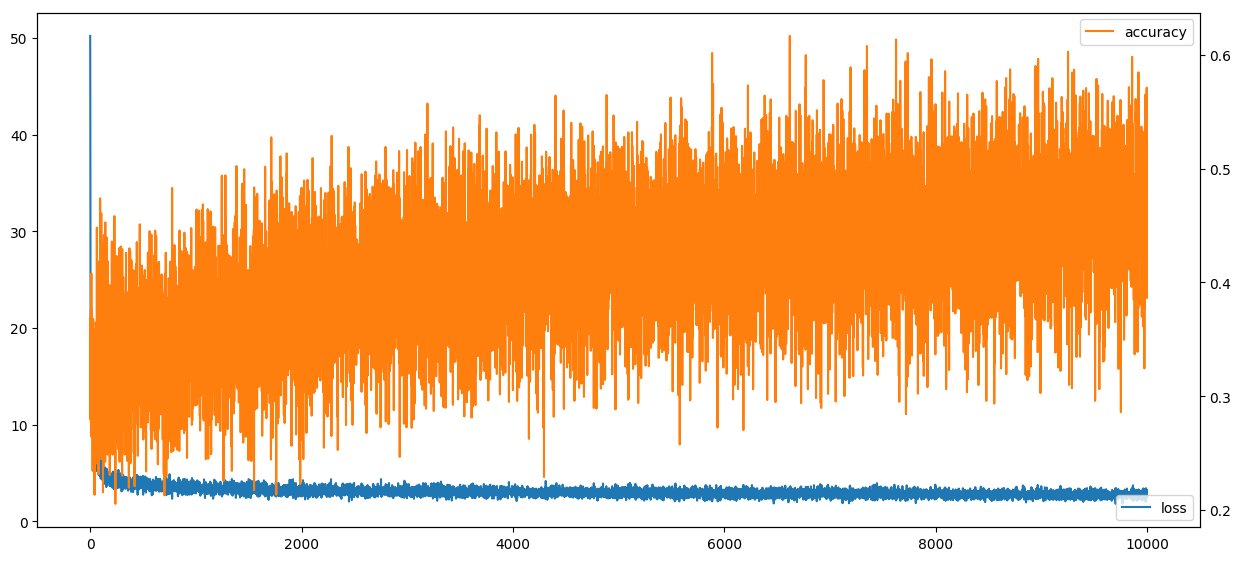

In [22]:
cmap = plt.get_cmap("tab10")

fig = plt.figure(figsize=(15,15),dpi=100)
ax1 = fig.add_subplot(2,1,1, facecolor='w')
ax1.plot(np.arange(1, history.shape[0] + 1), history[:, 0], label='loss')
ax2 = ax1.twinx()
ax2.plot(np.arange(1, history.shape[0] + 1), history[:, 1], label='accuracy', color=cmap(1))
ax1.legend(loc="lower right")
ax2.legend(loc="upper right")

plt.show()